### Optimal control of the FHN model
This notebook shows how to compute the optimal control signal for the FHN model for a simple example task.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [3]:
# We import the model
fhn = FHNModel()

# Some parameters to define stimulation signals
dt = fhn.params["dt"]
duration = 8.
amplitude = 1.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(np.arange(0,duration-0.2, dt)) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
fhn.params["duration"] = duration
x_init = 0.
y_init = 0.
fhn.params["xs_init"] = np.array([[x_init]])
fhn.params["ys_init"] = np.array([[y_init]])

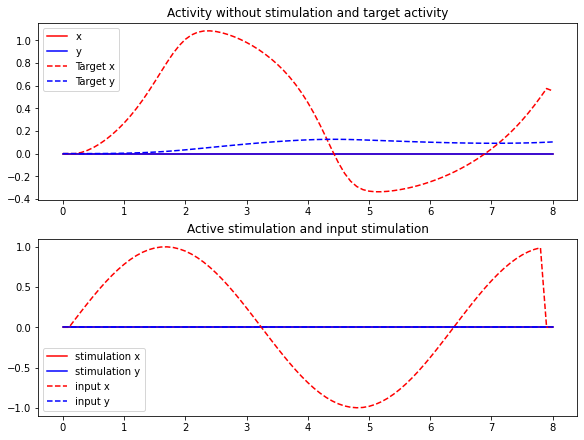

In [4]:
# We set the stimulus in x and y variables, and run the simulation
fhn.params["x_ext"] = input
fhn.params["y_ext"] = zero_input
fhn.run()

# Define the result of the stimulation as target
x_target = np.vstack( [0., fhn.x.T])
y_target = np.vstack( [0., fhn.y.T])
target = np.column_stack(( [x_target, y_target] )).T

# Remove stimuli and re-run the simulation
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
fhn.run()

# combine initial value and simulation result to one array
x = np.vstack( [x_init, fhn.x.T])
y = np.vstack( [y_init, fhn.y.T])

fig, ax = plt.subplots( 2,1, figsize=(8,6), constrained_layout=True)

# Plot the target (dashed line) and unperturbed activity
t_array = np.arange(0, duration+dt, dt)

ax[0].plot(t_array, x, label="x", color=color_x)
ax[0].plot(t_array, y, label="y", color=color_y)
ax[0].plot(t_array, x_target, linestyle='dashed', label="Target x", color=color_x)
ax[0].plot(t_array, y_target, linestyle='dashed', label="Target y", color=color_y)
ax[0].legend()
ax[0].set_title("Activity without stimulation and target activity")

# Plot the target control signal (dashed line) and "initial" zero control signal
ax[1].plot(t_array, zero_input[0,:], label="stimulation x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], label="stimulation y", color=color_y)
ax[1].plot(t_array, input[0,:], linestyle='dashed', label="input x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], linestyle='dashed', label="input y", color=color_y)
ax[1].legend()
ax[1].set_title("Active stimulation and input stimulation")

plt.show()

Cost in iteration 1: 12.894114922818574


/home/lena/Promotion/neurolib/neurolib/optimal_control/oc_fhn/oc_fhn_jit.py:44: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, C))
  - (fx[:, ind + 1] + adjoint_state[:, ind + 1] @ hx[ind + 1]) * dt
/home/lena/.local/lib/python3.9/site-packages/numba/core/typing/npydecl.py:937: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


Cost in iteration 2: 11.247274458295534
Cost in iteration 100: 0.22056999771689464
Cost in iteration 200: 0.05434322664595814
Cost in iteration 300: 0.019898878657677362
Cost in iteration 400: 0.008853777462356244
Cost in iteration 500: 0.00438083243038282


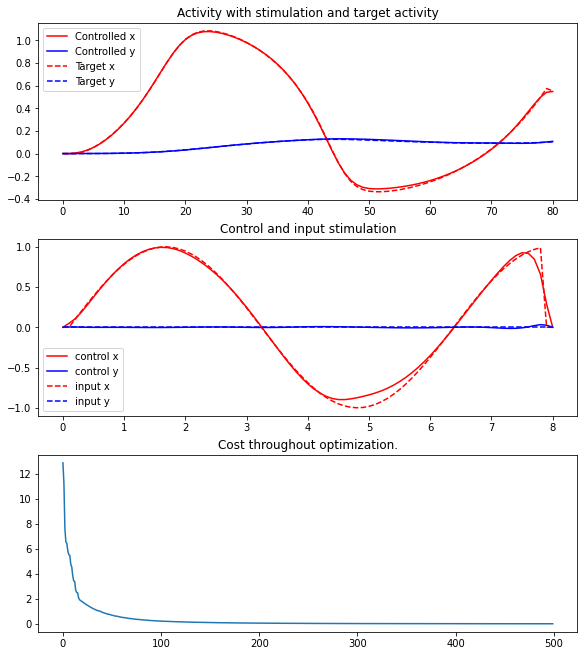

In [5]:
# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
fhn_controlled = oc_fhn.OcFhn(fhn, target, w_p=1, w_2=0, print_array=[1,2,100,200,300,400,500])


# We run 500 iterations of the optimal control gradient descent algorithm
fhn_controlled.optimize(500)

# combine the initial values and time series of controlled model to one array
x_oc = np.vstack( [fhn_controlled.model.params["xs_init"], fhn_controlled.model.x.T])
y_oc = np.vstack( [fhn_controlled.model.params["ys_init"], fhn_controlled.model.y.T])

control = fhn_controlled.control


fig, ax = plt.subplots( 3,1, figsize=(8,9), constrained_layout=True)

# Plot the target (dashed line) and controlled activity
ax[0].plot(x_oc, label="Controlled x", color=color_x)
ax[0].plot(y_oc, label="Controlled y", color=color_y)
ax[0].plot(x_target, linestyle='dashed', label="Target x", color=color_x)
ax[0].plot(y_target, linestyle='dashed', label="Target y", color=color_y)
ax[0].legend()
ax[0].set_title("Activity with stimulation and target activity")

# Plot the target control signal (dashed line) and control signal after 500 iterations
ax[1].plot(t_array, control[0,:], label="control x", color=color_x)
ax[1].plot(t_array, control[1,:], label="control y", color=color_y)
ax[1].plot(t_array, input[0,:], linestyle='dashed', label="input x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], linestyle='dashed', label="input y", color=color_y)
ax[1].legend()
ax[1].set_title("Control and input stimulation")

# Plot the cost as function of iteration
ax[2].plot(fhn_controlled.cost_history)
ax[2].set_title("Cost throughout optimization.")
plt.show()

In [6]:
# Do another 100 iterations if you want to
# repeated execution will continue with further 100 iterations
fhn_controlled.optimize(100)

Cost in iteration 1: 0.004380687741814681
Cost in iteration 2: 0.004330184324394621
Cost in iteration 100: 0.0023681111908086657


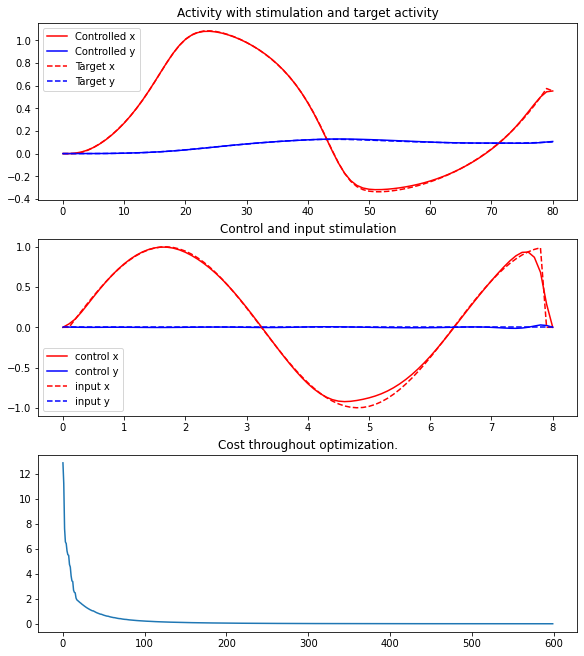

In [7]:

x_oc = np.vstack( [fhn_controlled.model.params["xs_init"], fhn_controlled.model.x.T])
y_oc = np.vstack( [fhn_controlled.model.params["ys_init"], fhn_controlled.model.y.T])

control = fhn_controlled.control

# Plot the results again
fig, ax = plt.subplots( 3,1, figsize=(8,9), constrained_layout=True)

ax[0].plot(x_oc, label="Controlled x", color=color_x)
ax[0].plot(y_oc, label="Controlled y", color=color_y)
ax[0].plot(x_target, linestyle='dashed', label="Target x", color=color_x)
ax[0].plot(y_target, linestyle='dashed', label="Target y", color=color_y)
ax[0].legend()
ax[0].set_title("Activity with stimulation and target activity")

ax[1].plot(t_array, control[0,:], label="control x", color=color_x)
ax[1].plot(t_array, control[1,:], label="control y", color=color_y)
ax[1].plot(t_array, input[0,:], linestyle='dashed', label="input x", color=color_x)
ax[1].plot(t_array, zero_input[0,:], linestyle='dashed', label="input y", color=color_y)
ax[1].legend()
ax[1].set_title("Control and input stimulation")

ax[2].plot(fhn_controlled.cost_history)
ax[2].set_title("Cost throughout optimization.")
plt.show()